<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/mnist-multilayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A deep feedforward network with arbitrary depth

In this exercise we build a deep feedforward neural network to recognize handwrittne digits (the MNIST data). The code has many tweekable parameters, in particular the number and width of layers. But as you will see adding more layers slows down the convergence considerably.


The usual imports plus gzip and pickle to read the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
#import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers

Important to be able to diplay matplotlib plots inline in the notebook

In [2]:
%matplotlib inline

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

The data are in compressed pickle format. 

In [4]:
def load_dataset():
  # tensorflow assumes the input and output are row vectors
  # where as in our implementation we use them as column vectors
    tr,te=keras.datasets.mnist.load_data()
    X=tr[0].astype("float32")/255
    Y=tr[1]
    Y=Y.reshape(1,len(Y))
    V=np.zeros((10,Y.shape[1]))
    for j in range(Y.shape[1]):
        V[Y[0,j],j]=1
        
    Y=V.astype("float32")
    test_data=te[0].astype("float32")/255
    test_labels=te[1].astype("float32")
    test_labels=test_labels.reshape(1,len(test_labels))
    return X,Y.T,test_data,test_labels.T


The activation function is sigmoid

In [5]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

This function plots some of the misclassified data in order for us to have an idea what when wrong.

In [6]:
def print_misclassified(test_data,test_labels,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    fig=plt.figure()
    fig.tight_layout()
    plt.subplots_adjust( wspace=1, hspace=1)

    for i in range(output.shape[1]):
        label=np.argmax(output[:,i])
        if label != test_labels[0,i]:
            if count>40:
                break
            subfig=count%40+1
            count=count+1
            img=test_data[:,i].reshape(28,28)
            t=fig.add_subplot(4,10,subfig)
            #t.set_title(str(i))
            t.set_title(str(label))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img,cmap='gray_r')



Returns the number of correct predictions

In [7]:
def evaluate(test_data,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    for i in range(output.shape[1]):
        if np.argmax(output[:,i])==test_labels[0,i]:
            count=count+1
    return count

The usual cross Entropy cost

In [8]:
def compute_cost(Y,b,w):
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    As=forward_propagation(X,b,w)
    # recall that As contains the "output" of all layers
    # including the input As[0] and the final output As[-1]
    output=As[-1]
    logprobs = np.log(output)*Y+np.log(1-output)*(1-Y)
    cost = -np.sum(logprobs)/m

    count=0
    for i in range(output.shape[1]):
        if (np.argmax(output[:,i])==np.argmax(Y[:,i])):
            count=count+1

    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost,count


The weights are initialized randomly and the biases are initially set to zero

In [9]:
def initialize_parameters(width):    
    weights=[]
    biases=[]
    for i in range(len(width)-1):
        print("size {},{}".format(width[i+1],width[i]))
        w=np.random.randn(width[i+1],width[i])
        b=np.zeros((width[i+1],1))
        weights.append(w)
        biases.append(b)

    return biases,weights


Forward propagation over all the layers but also retain the intermediate results.
For example below As[0] is the input, As[1] is the output of the first layer,..., and As[-1] (the last) is the output

In [10]:
def forward_propagation(X,biases,weights):
    a=X
    As=[X]
    for w,b in zip(weights,biases):
       z=np.dot(w,a)+b
       a=sigmoid(z)
       As.append(a)

    return As

In [11]:
def backward_propagation(X,Y,biases,weights):

    As=forward_propagation(X,biases,weights)
    m = X.shape[1]
    
    nlayers=len(biases)
    dz=As[nlayers]-Y
#   uncomment below if you want to use mean squared error
#    dz=dz*As[nlayers]*(1-As[nlayers])
    gradb=[]
    gradw=[]
    for i in range(nlayers,0,-1):
        db=np.sum(dz,axis=1,keepdims=True)/m
        dw=np.dot(dz,As[i-1].T)/m
        dz=np.dot(weights[i-1].T,dz)*As[i-1]*(1-As[i-1])
        gradb.insert(0,db)
        gradw.insert(0,dw)
    
    return gradb,gradw

In [12]:
def update_parameters(biases,weights, gradb,gradw, learning_rate):


    for i in range(len(biases)):
        weights[i]=weights[i]-learning_rate*gradw[i]
        biases[i]=biases[i]-learning_rate*gradb[i]

    return biases,weights

Initialize the parameters


In [13]:
def GD(X, Y, test_data,width,batch_size,num_iterations, learning_rate,print_cost=False):

    #n_x=X.shape[0]
    #n_y=Y.shape[0]
    biases,weights=initialize_parameters(width)
    
    for i in range(0, num_iterations):
        cost,count = compute_cost(Y,biases,weights)
        for k in range(0,X.shape[1],batch_size):
            idx=[random.randint(0,Y.shape[1]-1) for s in range(batch_size)]
            yb=Y[:,idx]
            xb=X[:,idx]
            gradb,gradw=backward_propagation(xb,yb,biases,weights)
            biases,weights=update_parameters(biases,weights,gradb,gradw,learning_rate)    

        if i%1 ==0 : 
            print(len(weights))   
            count_test=evaluate(test_data,biases,weights)
            print ("Cost after iteration %i: %f" %(i, cost))
            print("count after iteration %i is %i" %(i,count))
            print("test count after iteration %i is %i" %(i,count_test))
    return biases,weights

In [14]:
X, Y,test_data,test_labels = load_dataset()
X=X.reshape(60000,784)
test_data=test_data.reshape(10000,784)
X=X.T
Y=Y.T
test_data=test_data.T
test_labels=test_labels.T

n_x=X.shape[0]
n_y=Y.shape[0]
width=[n_x,128,64,n_y]
biases,weights= GD(X, Y,test_data,width,batch_size=64,learning_rate=3,
                num_iterations =10, print_cost=True)


count=evaluate(test_data,biases,weights)
A=forward_propagation(X,biases,weights)
print(A[-1].shape)
print(len(A))


11493376/11490434 [==============================] - 0s 0us/step
size 128,784
size 64,128
size 10,64
3
Cost after iteration 0: 30.129112
count after iteration 0 is 5755
test count after iteration 0 is 9152
3
Cost after iteration 1: 0.514947
count after iteration 1 is 55177
test count after iteration 1 is 9314
3
Cost after iteration 2: 0.395329
count after iteration 2 is 56357
test count after iteration 2 is 9416
3
Cost after iteration 3: 0.307875
count after iteration 3 is 57191
test count after iteration 3 is 9462
3
Cost after iteration 4: 0.265603
count after iteration 4 is 57555
test count after iteration 4 is 9499
3
Cost after iteration 5: 0.230051
count after iteration 5 is 57906
test count after iteration 5 is 9496
3
Cost after iteration 6: 0.223979
count after iteration 6 is 57996
test count after iteration 6 is 9538
3
Cost after iteration 7: 0.207892
count after iteration 7 is 58139
test count after iteration 7 is 9562
3
Cost after iteration 8: 0.171490
count after iteration 8 

Prints some of the misclassified digits. The top on each digit shows the (wrong) prediction.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


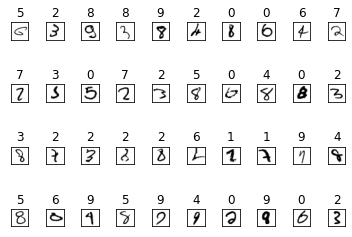

In [15]:
print_misclassified(test_data,test_labels,biases,weights)
